In [3]:
%matplotlib notebook

import pandas as pd
import os

# Goal

1. 특정 행위자에 대한 필터 
2. 특정 URL 접속 기록에 대한 Timestamp 분석
3. 해당 Timestamp 의 CPS 를 계산

# 참조 



- [IIS 로그 Pandas 분석](http://s3lab.deusto.es/analizando-logs-iis-pandas/)
- 


In [4]:
# 전처리
def parse_logs(path, ext='.log', newline='\r\n'):
    logs = []
    for file in os.listdir(path):
        if file.endswith(ext):
            # First, we read all the lines of the file, excluding the coments
            file = [x.replace('\r', '').replace('\n', '').split(' ') for x in open(path + '/' + file, newline='\r\n').readlines() 
                    if x[0] is not '#']

            # We append the files
            logs += file
    return logs

In [5]:
# W3SVC 칼럼 리스트 추출
def parse_columns_from_w3svc(path, start_with='#Fields', newline='\r\n'):
    columns = [x.replace('\r', '').replace('\n', '').split(' ') for x in open(path, newline=os.linesep).readlines() if x.lower().find('#Fields:'.lower()) > -1][0]
    return columns[1:]

In [6]:
# pd.read_csv(r'./u_ex171118-sample.txt', sep=r'\s+', encoding='utf8', error_bad_lines=False)
logs = parse_logs(r'./')

# 로그 필터 결과 검증

parse_logs 메서드는 #으로 시작하는 구문을 필터링 하도록 되어 있으며 그 결과를 검증 시에 배열의 길이로 한다.

또한, 명령어 상에서 grep 을 이용하여 크로스 체크가 가능하다.

```bash
cat ./[FILE_NAME] | grep -v '^#' | wc -l
cat ./[FILE_NAME] | wc -l
```


In [7]:
len(logs)

623

In [8]:

df = pd.DataFrame(logs)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,623,623,623,623,623,623,623,623,623,623,623,623,623,623,623
unique,1,214,1,3,36,4,2,1,1,3,22,7,1,2,459
top,2018-12-08,19:54:54,::1,GET,/css/site.css,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,156
freq,623,10,623,590,56,578,615,623,623,608,175,495,623,610,5


In [9]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2018-12-08,18:46:10,::1,DEBUG,/,-,50669,-,::1,-,-,200,0,64,8582
1,2018-12-08,18:46:16,::1,GET,/,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,-,200,0,0,11083
2,2018-12-08,18:46:16,::1,GET,/css/site.css,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,470
3,2018-12-08,18:46:16,::1,GET,/lib/bootstrap/dist/css/bootstrap.css,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,565
4,2018-12-08,18:46:16,::1,GET,/images/banner3.svg,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,395


In [10]:
# 칼럼명을 지정
df.columns = parse_columns_from_w3svc(r'./ex181208.log')

In [11]:
df.head()

,date,time,s-ip,cs-method,cs-uri-stem,cs-uri-query,s-port,cs-username,c-ip,cs(User-Agent),cs(Referer),sc-status,sc-substatus,sc-win32-status,time-taken
0,2018-12-08,18:46:10,::1,DEBUG,/,-,50669,-,::1,-,-,200,0,64,8582
1,2018-12-08,18:46:16,::1,GET,/,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,-,200,0,0,11083
2,2018-12-08,18:46:16,::1,GET,/css/site.css,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,470
3,2018-12-08,18:46:16,::1,GET,/lib/bootstrap/dist/css/bootstrap.css,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,565
4,2018-12-08,18:46:16,::1,GET,/images/banner3.svg,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,395


# 타임스탬프 변환

date 와 time 칼럼을 조합하여 datetime 으로 변환하고 새로운 칼럼을 생성하되 index 로 만든다.

In [12]:
df.insert(0, 'datetime', pd.to_datetime(df.apply(lambda x: x['date'] + ' ' + x['time'], 1)))

df = df.drop(['date', 'time'], 1)
 
# Creamos un índice con el tiempo
df.index = df['datetime']
 
df.drop('datetime',1)

,s-ip,cs-method,cs-uri-stem,cs-uri-query,s-port,cs-username,c-ip,cs(User-Agent),cs(Referer),sc-status,sc-substatus,sc-win32-status,time-taken
datetime,,,,,,,,,,,,,
2018-12-08 18:46:10,::1,DEBUG,/,-,50669,-,::1,-,-,200,0,64,8582
2018-12-08 18:46:16,::1,GET,/,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,-,200,0,0,11083
2018-12-08 18:46:16,::1,GET,/css/site.css,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,470
2018-12-08 18:46:16,::1,GET,/lib/bootstrap/dist/css/bootstrap.css,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,565
2018-12-08 18:46:16,::1,GET,/images/banner3.svg,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,395
2018-12-08 18:46:16,::1,GET,/images/banner2.svg,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,425
2018-12-08 18:46:17,::1,GET,/lib/jquery/dist/jquery.js,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,891
2018-12-08 18:46:17,::1,GET,/images/banner4.svg,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,914
2018-12-08 18:46:17,::1,GET,/js/site.js,v=ji3-IxbEzYWjzzLCGkF1KDjrT2jLbbrSYXw-AhMPNIA,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,942


In [13]:
df.describe()

,datetime,s-ip,cs-method,cs-uri-stem,cs-uri-query,s-port,cs-username,c-ip,cs(User-Agent),cs(Referer),sc-status,sc-substatus,sc-win32-status,time-taken
count,623,623,623,623,623,623,623,623,623,623,623,623,623,623
unique,214,1,3,36,4,2,1,1,3,22,7,1,2,459
top,2018-12-08 20:02:43,::1,GET,/css/site.css,-,44323,-,::1,Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+Appl...,https://localhost:44323/,200,0,0,156
freq,10,623,590,56,578,615,623,623,608,175,495,623,610,5
first,2018-12-08 18:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2018-12-08 21:29:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Nos quedamos con la columna de tiempo
datetimeDF = df.ix[0:, ['datetime']]
 
server_times = []
for i, row in datetimeDF.iterrows():
    server_times.append(row['datetime'])
 
# Y ordenamos la lista    
server_times.sort()
 
time_until_next = []
for i in range(1, len(server_times) - 1):
    time_diff = (server_times[i] - server_times[i-1]).seconds
    time_until_next.append(time_diff)

/home/secu/anaconda3/envs/logarithm/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


<IPython.core.display.Javascript object>


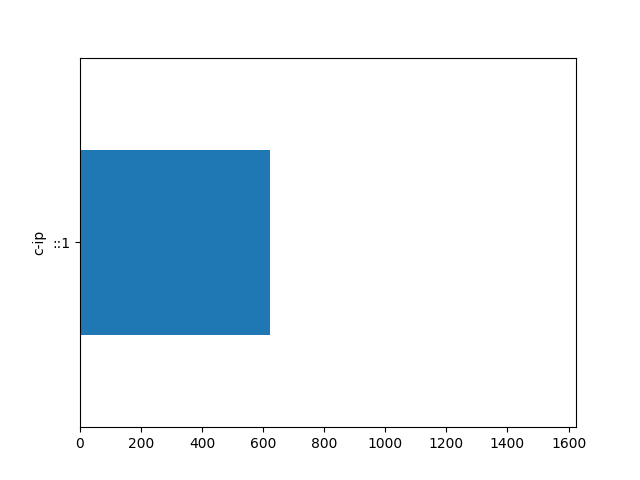

/home/secu/anaconda3/envs/logarithm/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


In [15]:
pd.Series(time_until_next).hist(normed=True)

In [16]:
ip = df.groupby('c-ip').size()
ip

c-ip
::1    623
dtype: int64

In [17]:
ip.sort_values(ascending=True)
ip[-10:].plot(kind='barh')

In [18]:
# Convertimos la columna a columna de ints
df['sc-status'] = df['sc-status'].astype(int)
 
t_span = '5t'
df_404 = df['sc-status'][df['sc-status'] == 404].resample(t_span, how='count')
df_403 = df['sc-status'][df['sc-status'] == 403].resample(t_span, how='count')
df_301 = df['sc-status'][df['sc-status'] == 301].resample(t_span, how='count')
df_302 = df['sc-status'][df['sc-status'] == 302].resample(t_span, how='count')
df_304 = df['sc-status'][df['sc-status'] == 304].resample(t_span, how='count')
df_200 = df['sc-status'][df['sc-status'] == 200].resample(t_span, how='count')



status_df = pd.DataFrame({'Not Found':df_404, 'Forbidden':df_403, 'Moved Permanently':df_301, 'Moved Temporaly': df_302, 'Not Modified':df_304, 'OK':df_200})
status_df

/home/secu/anaconda3/envs/logarithm/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  """
/home/secu/anaconda3/envs/logarithm/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  
/home/secu/anaconda3/envs/logarithm/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  import sys
/home/secu/anaconda3/envs/logarithm/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  
/home/secu/anaconda3/envs/logarithm/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  if __name__ == '__main__':
/home/secu/anaconda3/envs/logarithm/lib/python3.5/site-p

,Forbidden,Moved Permanently,Moved Temporaly,Not Found,Not Modified,OK
datetime,,,,,,
2018-12-08 18:45:00,NaN,NaN,NaN,NaN,NaN,22
2018-12-08 18:50:00,NaN,NaN,NaN,NaN,4.0,32
2018-12-08 18:55:00,NaN,NaN,1.0,NaN,28.0,26
2018-12-08 19:00:00,NaN,NaN,0.0,NaN,8.0,26
2018-12-08 19:05:00,NaN,NaN,1.0,NaN,16.0,8
2018-12-08 19:10:00,NaN,NaN,0.0,NaN,12.0,29
2018-12-08 19:15:00,NaN,NaN,0.0,NaN,3.0,14
2018-12-08 19:20:00,NaN,NaN,0.0,NaN,8.0,1
2018-12-08 19:25:00,NaN,NaN,0.0,NaN,1.0,9


<IPython.core.display.Javascript object>


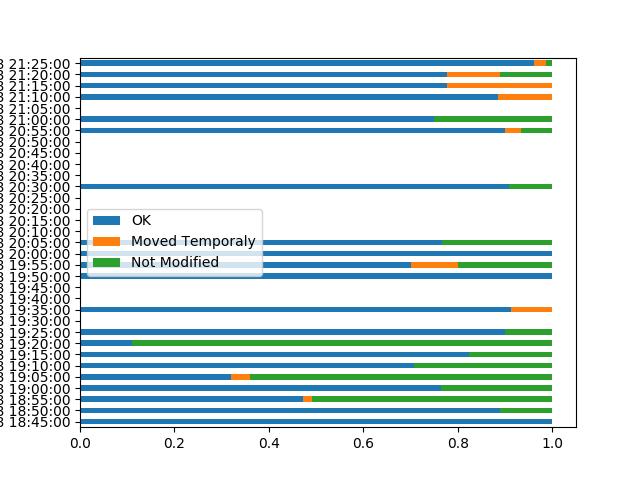

In [19]:
normed_subset = status_df[['OK','Moved Temporaly', 'Not Modified']].div(status_df[['OK','Moved Temporaly', 'Not Modified']].sum(1), axis = 0)
 
normed_subset.plot(kind='barh', stacked=True)